In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import cv2

In [17]:
def convolve(filter,mat,padding,strides):
    result = None
    filter_size = filter.shape
    mat_size = mat.shape
    if len(filter_size) == 2:
        if len(mat_size) == 3:
            channel = []
            for i in range(mat_size[-1]):
                pad_mat = np.pad(mat[:,:,i], ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
                temp = []
                for j in range(0,mat_size[0],strides[1]):
                    temp.append([])
                    for k in range(0,mat_size[1],strides[0]):
                        val = (filter*pad_mat[j:j+filter_size[0],k:k+filter_size[1]]).sum()
                        temp[-1].append(val)
                channel.append(np.array(temp))

            channel = tuple(channel)
            result = np.dstack(channel)
        elif len(mat_size) == 2:
            channel = []
            pad_mat = np.pad(mat, ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
            for j in range(0, mat_size[0], strides[1]):
                channel.append([])
                for k in range(0, mat_size[1], strides[0]):
                    val = (filter * pad_mat[j:j + filter_size[0],k:k + filter_size[1]]).sum()
                    channel[-1].append(val)


            result = np.array(channel)


    return result

In [18]:
def linear_convolve(filter,mat,padding=None,strides=[1,1]):
    result = None
    filter_size = filter.shape
    if len(filter_size) == 2 and 1 in filter_size:
        if padding == None or len(padding) < 2:
            if filter_size[1] == 1:
                padding = [filter_size[0]//2,filter_size[0]//2]
            elif filter_size[0] == 1:
                padding = [filter_size[1]//2,filter_size[1]//2]
        if filter_size[0] == 1:
            result = convolve(filter,mat,[0,0,padding[0],padding[1]],strides)
        elif filter_size[1] == 1:
            result = convolve(filter, mat, [padding[0],padding[1],0,0], strides)

    return result

In [19]:
def _2_dim_divided_convolve(filter,mat):
    result = None
    if 1 in filter.shape:
        result = linear_convolve(filter,mat)
        result = linear_convolve(filter.T,result)

    return result

In [20]:
def judge_connect(m2,threshold):
    e = 0.01
    s = []
    cood = []
    for i in range(m2.shape[0]):
        cood.append([])
        for j in range(m2.shape[1]):
            cood[-1].append([i,j])
            if abs(m2[i,j] - 255) < e:
                s.append([i,j])
    cood = np.array(cood)

    while not len(s) == 0:
        index = s.pop()
        jud = m2[max(0, index[0] - 1):min(index[0] + 2, m2.shape[1]), max(0, index[1] - 1):min(index[1] + 2, m2.shape[0])]
        jud_i = cood[max(0, index[0] - 1):min(index[0] + 2, cood.shape[1]), max(0, index[1] - 1):min(index[1] + 2, cood.shape[0])]
        jud = (jud > threshold[0])&(jud < threshold[1])
        jud_i = jud_i[jud]
        for i in range(jud_i.shape[0]):
            s.append(list(jud_i[i]))
            m2[jud_i[i][0],jud_i[i][1]] = 255

    return m2

In [21]:
def decide_and_connect_edge(g_l,g_t,threshold = None):
    if threshold == None:
        lower_boundary = g_l.mean()*0.5
        threshold = [lower_boundary,lower_boundary*3]
    result = np.zeros(g_l.shape)

    for i in range(g_l.shape[0]):
        for j in range(g_l.shape[1]):
            is_local_extreme = True
            eight_neighborhood = g_l[max(0,i-1):min(i+2,g_l.shape[0]),max(0,j-1):min(j+2,g_l.shape[1])]
            if eight_neighborhood.shape == (3,3):
                if g_t[i,j] <= -1:
                    x = 1/g_t[i,j]
                    first = eight_neighborhood[0,1] + (eight_neighborhood[0,1] - eight_neighborhood[0,0])*x
                    x = -x
                    second = eight_neighborhood[2,1] + (eight_neighborhood[2,2] - eight_neighborhood[2,1])*x
                    if not (g_l[i,j] > first and g_l[i,j] > second):
                        is_local_extreme = False
                elif g_t[i,j] >= 1:
                    x = 1 / g_t[i, j]
                    first = eight_neighborhood[0, 1] + (eight_neighborhood[0, 2] - eight_neighborhood[0, 1]) * x
                    x = -x
                    second = eight_neighborhood[2, 1] + (eight_neighborhood[2, 1] - eight_neighborhood[2, 0]) * x
                    if not (g_l[i, j] > first and g_l[i, j] > second):
                        is_local_extreme = False
                elif g_t[i,j] >= 0 and g_t[i,j] < 1:
                    y = g_t[i, j]
                    first = eight_neighborhood[1, 2] + (eight_neighborhood[0, 2] - eight_neighborhood[1, 2]) * y
                    y = -y
                    second = eight_neighborhood[1, 0] + (eight_neighborhood[1, 0] - eight_neighborhood[2, 0]) * y
                    if not (g_l[i, j] > first and g_l[i, j] > second):
                        is_local_extreme = False
                elif g_t[i,j] < 0 and g_t[i,j] > -1:
                    y = g_t[i, j]
                    first = eight_neighborhood[1, 2] + (eight_neighborhood[1, 2] - eight_neighborhood[2, 2]) * y
                    y = -y
                    second = eight_neighborhood[1, 0] + (eight_neighborhood[0, 0] - eight_neighborhood[1, 0]) * y
                    if not (g_l[i, j] > first and g_l[i, j] > second):
                        is_local_extreme = False
            if is_local_extreme:
                result[i,j] = g_l[i,j]

    result[result>=threshold[1]] = 255
    result[result<=threshold[0]] = 0


    result = judge_connect(result,threshold)
    result[result!=255] = 0
    return result

In [22]:
def standard_normal_distribution(x,sigma):
    E = -0.5/(sigma*sigma)
    return 1/(math.sqrt(2*math.pi)*sigma)*math.exp(x*x*E)

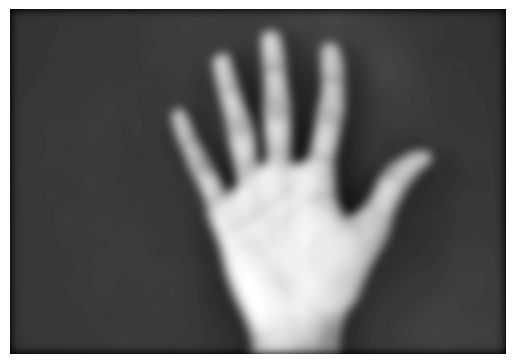

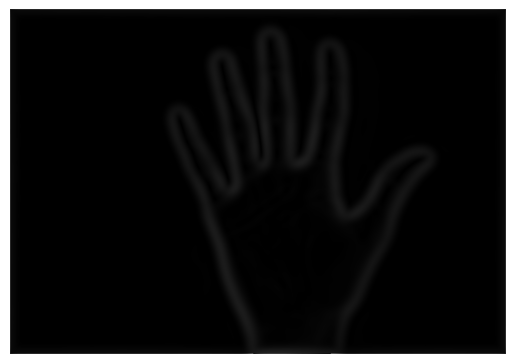

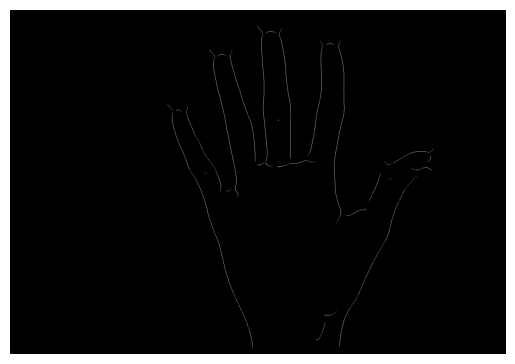

error: OpenCV(4.9.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [23]:
sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

pic_path = './img/'
pics = os.listdir(pic_path)

for i in pics:
    if i[-4:] == '.png'or i[-4:] == '.jpg' or i[-5:] == '.jpeg':
        filename = pic_path + i
        oriImg = plt.imread(filename)
        if i[-4:] == '.png':
            oriImg = oriImg*255
        img = oriImg.mean(axis=-1)
        sigma = 17
        dim = int(np.round(6*sigma+1))
        if dim % 2 == 0:
            dim += 1
        linear_gaussian_filter = [np.abs(t - (dim//2)) for t in range(dim)]

        linear_gaussian_filter = np.array([[standard_normal_distribution(t,sigma) for t in linear_gaussian_filter]])
        linear_gaussian_filter = linear_gaussian_filter/linear_gaussian_filter.sum()

        img2 = _2_dim_divided_convolve(linear_gaussian_filter,img)
        # img2 = convolve(Gaussian_filter_5, img, [2, 2, 2, 2], [1, 1])

        plt.imshow(img2.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.show()

        img3 = convolve(sobel_kernel_x,img2,[1,1,1,1],[1,1])
        img4 = convolve(sobel_kernel_y,img2,[1,1,1,1],[1,1])

        gradiant_length = (img3**2+img4**2)**(1.0/2)

        img3 = img3.astype(np.float64)
        img4 = img4.astype(np.float64)
        img3[img3==0]=0.00000001
        gradiant_tangent = img4/img3

        plt.imshow(gradiant_length.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.show()

        #lower_boundary = 50
        final_img = decide_and_connect_edge(gradiant_length,gradiant_tangent)
        final_img = final_img[1:-1, 1:-1]

        plt.imshow(final_img.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.show()

        # orb = cv2.ORB.create(9)
        # kp = orb.detect(final_img, None)
        # for i in range(len(kp)):
        #     print(f"keypoint coordinate {i} : {kp[i].pt}")
        # kp, des = orb.compute(final_img, kp)

        # keypoint_image = cv2.drawKeypoints(final_img, kp, None, color=(0, 255, 0), flags=0)
        # plt.imshow(keypoint_image.astype(np.uint8), cmap='gray')
        # plt.axis('off')
        # plt.show()

        cv2.waitKey(0)